In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [14]:
class Residual(nn.Module):
    def __init__(self, in_channels, out_channels, use_1x1conv=False, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               padding=1, stride=stride)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1,
                                   stride=stride)
        else:
            self.conv3 = None

        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))

        if self.conv3 is not None:
            X = self.conv3(X)
        Y += X
        return Y

In [15]:
res_block = Residual(3, 3, True, stride=2)
X = torch.rand((1, 3, 8 ,8))
res_block(X).shape

torch.Size([1, 3, 4, 4])

In [18]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, stride=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [19]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

In [20]:
X = torch.rand((1, 1, 224, 224))
for module in net:
    X = module(X)
    print(module.__class__.__name__, X.shape)

Sequential torch.Size([1, 64, 56, 56])
Sequential torch.Size([1, 64, 56, 56])
Sequential torch.Size([1, 128, 28, 28])
Sequential torch.Size([1, 256, 14, 14])
Sequential torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d torch.Size([1, 512, 1, 1])
Flatten torch.Size([1, 512])
Linear torch.Size([1, 10])


In [21]:
total_params = 0
for name, param in net.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Count: {param.nelement()} | {param.data.dtype}")
    total_params += param.nelement()

print(f"Total parameters count: {total_params}")

Layer: 0.0.weight | Size: torch.Size([64, 1, 7, 7]) | Count: 3136 | torch.float32
Layer: 0.0.bias | Size: torch.Size([64]) | Count: 64 | torch.float32
Layer: 0.1.weight | Size: torch.Size([64]) | Count: 64 | torch.float32
Layer: 0.1.bias | Size: torch.Size([64]) | Count: 64 | torch.float32
Layer: 1.0.conv1.weight | Size: torch.Size([64, 64, 3, 3]) | Count: 36864 | torch.float32
Layer: 1.0.conv1.bias | Size: torch.Size([64]) | Count: 64 | torch.float32
Layer: 1.0.conv2.weight | Size: torch.Size([64, 64, 3, 3]) | Count: 36864 | torch.float32
Layer: 1.0.conv2.bias | Size: torch.Size([64]) | Count: 64 | torch.float32
Layer: 1.0.bn1.weight | Size: torch.Size([64]) | Count: 64 | torch.float32
Layer: 1.0.bn1.bias | Size: torch.Size([64]) | Count: 64 | torch.float32
Layer: 1.0.bn2.weight | Size: torch.Size([64]) | Count: 64 | torch.float32
Layer: 1.0.bn2.bias | Size: torch.Size([64]) | Count: 64 | torch.float32
Layer: 1.1.conv1.weight | Size: torch.Size([64, 64, 3, 3]) | Count: 36864 | torch.f

loss 0.131, train acc 0.953, test acc 0.838
1295.7 examples/sec on cuda:0


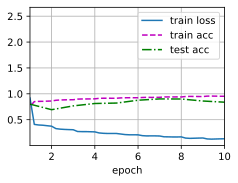

In [23]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [24]:
X_example, y_example = next(iter(train_iter))

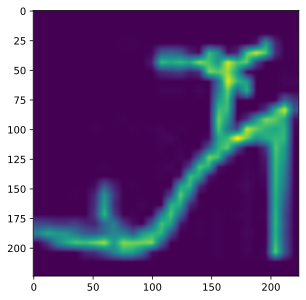

In [27]:
d2l.plt.imshow(d2l.np.transpose(X_example[0].numpy(), (1, 2, 0)))

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

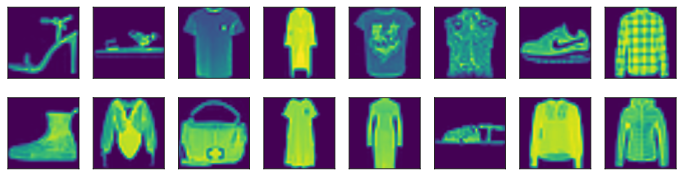

In [31]:
d2l.show_images(d2l.np.transpose(X_example[0:16].numpy(), (0, 2, 3, 1)), 
                2, 8, titles=None, scale=1.5)

In [50]:
def predict_ch3_gpu(net, test_iter, size, n=6, device="cuda"):
    net.eval()
    for X, y in test_iter:
        break
    X = X.to(device)
    # y = y.to(device)
    net = net.to(device)
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(d2l.argmax(net(X).to("cpu"), axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        d2l.reshape(X[0:n].to("cpu"), (n, ) + size), 1, n, titles=titles[0:n])

torch.Size([256, 10])


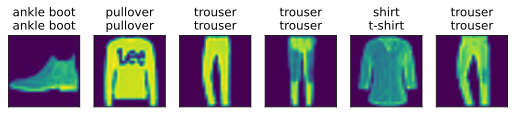

In [51]:
predict_ch3_gpu(net, test_iter, (224, 224))
# X_example, y_example = next(iter(train_iter))
# net(X_example).shape